# Work for Tom Sargent
By Brandon Kaplowitz

Date: June 1, 2018 

## Problem 1.1 from "Marching Orders"
### Description of the Problem
We take from 0 to T $$y_t=\theta_ty_{t-1} + \varepsilon_t$$ $$ \theta_{t} = \theta_{t-1}+\nu_t $$
where  
$$
\begin{equation}
\left(\begin{matrix}
\varepsilon_t \\
\nu_t 
\end{matrix}\right) \sim \mathcal{N}\left(0,V\right) \ \text{and}  \ V= \left[ \begin{matrix} 
R & C \\
C & Q 
\end{matrix}\right].
\end{equation}
$$
We suppose initial state $\theta_0$ and $V$ are independent and their natural conjugate priors are
 $$\theta_0 \sim \mathbb{1}_{|\theta|<1}\mathcal{N}\left(\bar{\theta},\bar{P}\right) $$
 and 
 $$ V\sim \mathcal{IW}\left(\bar{V}^{-1}, T_0\right)$$ 
 where $\mathcal{IW}\left(S,df\right)$ is the inverse wishart distribution with scale matrix $S$ and degrees of freedom $df$. We suppose that $\left(\bar{\theta}, \bar{P}, \bar{V}^{-1} , T_0\right)$ are known and fixed.
 
 We  treat $\theta_t$ as a hidden state variable following a driftless random walk with the truncated Gaussian distribution:
 
 $$p\left(\theta_{t+1}|\theta_t,V\right) \propto \mathbb{1}_{|\theta_{t+1}| <1} \mathcal{N}\left(\theta_t,Q\right).$$
 
### Description of Algorithm

To solve this problem, we need to take the priors $\theta_0 \sim \mathbb{1}_{|\theta|<1}\mathcal{N}\left(\bar{\theta}, \bar{P}\right)$ and $V \sim \mathcal{IW}\left(\bar{V}^{-1}, T_0\right)$ and multiply them by their likelihoods to find their posteriors. The posterior is $$p\left(\theta^T,V|y^T\right) \underbrace{=}_{\text{By Bayes' Rule}} \frac{p\left(y^T|\theta^T,V\right)p\left(\theta^T,V\right)}{p\left(y^T\right)}= \frac{p\left(y^T|\theta^T,V
\right)p\left(\theta^T|V\right)p\left(V\right)}{p\left(y^T\right)}$$
$$ =\frac{\prod_{t=1}^{T}p\left(y_t|y_{t-1},\theta^T,V\right)\prod_{t=1}^{T}p\left(\theta_{t+1}|\theta_{t},V\right)p\left(\theta_0\right)p\left(V\right)}{p\left(y^T\right)} $$
We can see now that the first term is the likelihood, the second the Bayesian updating of $\theta$ from a prior on $\theta$ to a posterior on $\theta_t$ given the $\theta$ before it, and the last two terms the prior for $\theta_0$ and $V$. 
Note that: $$p\left(y_t|y_{t-1}, \theta^T,V\right)=  p\left(\theta_t y_{t-1}+\varepsilon_t|\theta_t, y_{t-1},\varepsilon_{t-1} \right)\underbrace{=}_{iid}p\left(\varepsilon_t\right) \sim \mathcal{N}\left(\theta_t y_{t-1},R\right)$$
$$p\left(\theta_{t+1} | \theta_{t},V\right) \propto \mathbb{1}_{|\theta_{t+1}|<1}\mathcal{N}\left(\theta_t,Q\right)$$

The procedure we use is as follows. We use a modification to MCMC called HMC, as well as the Metropolis-Hastings for speed comparison. We compute the numerator of the fraction given above to give a conditional pdf. We then take a proposal distribution, draw a new point from the proposal. If the ratio of the numerator of the new point to the old point is greater than 1 we accept. Otherwise we accept with the probability of the ratio times a correction for asymmetric distributions. We can ignore the denominator as we are examining the ratio of two pdfs, both of which will have the same denominator, which is a normalization.
We now implement this procedure in PYMC3.
## Implementation

To actually implement this model, since $p(y_t|y_{t-1},\theta^T,V)$ is incredibly difficult to calculate explicitly, we will use the built in Hierarchical GLM modeller in PYMC3. 

The model we will use looks as follows:

![title](Source.gv.png)

In [1]:
%reset -f
%pylab inline
import pymc3 as pm
import numpy as np
import matplotlib
from matplotlib import rc
import seaborn as sns
import theano as theano
rc('font',**{'family':'sans-serif','sans-serif':['DejaVu Sans']})
matplotlib.rcParams['mathtext.fontset'] = 'stixsans'
import matplotlib.pylab as plt 
plt.rc('mathtext', fontset="cm")
import scipy.stats as st
from pymc3.distributions import Continuous, Normal, MvNormal
import theano.tensor as tt
from theano import scan
from pymc3.util import get_variable_name
from pymc3.distributions.continuous import get_tau_sd, Normal, Flat
from pymc3.distributions.dist_math import Cholesky
from pymc3.distributions import multivariate
from pymc3.distributions import distribution
matplotlib.rcParams['font.sans-serif']='DejaVu Sans'
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
plt.style.use('ggplot')

Populating the interactive namespace from numpy and matplotlib


/Users/bkaplowitz-local/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
T=50
theta_true=np.empty([T+1,1])
y_obs=np.empty([T+1,1])
theta_true[0]=st.norm.rvs(loc=.3,scale=.2)
while (theta_true[0]>1 or theta_true[0]<-1):
    theta_true[0]=st.norm.rvs(loc=.3,scale=.2)
errs=st.multivariate_normal.rvs(mean=[0,0], cov=[[0.4, 0.3], [0.3, 0.5]], size=T+1)
nu=errs[:,0]
err=errs[:,1]
y_obs[0]=err[0]
for t in range(1,T+1):
    theta_true[t]=theta_true[t-1]+nu[t]
    while (theta_true[t]>1 or theta_true[t]<-1):
        theta_true[t]=st.norm.rvs(loc=theta_true[t-1], scale=np.sqrt(.5))
    y_obs[t]= theta_true[t]*y_obs[t-1]+err[t]
#fix constant values.

[[ 1.59722646]
 [-0.22992241]
 [ 0.41749801]
 [-0.38444927]
 [ 0.14744614]
 [-1.23790377]
 [ 0.57822715]
 [-0.25057637]
 [ 0.79886619]
 [ 0.07821051]
 [-0.19785457]
 [-0.66588957]
 [-0.38795343]
 [-0.43665071]
 [ 0.58880719]
 [-0.7610561 ]
 [ 0.51826793]
 [-1.5178431 ]
 [ 1.11049995]
 [ 0.32942241]
 [-0.3821152 ]
 [-1.68091212]
 [-0.31440011]
 [-0.38629911]
 [ 0.40963855]
 [-0.51390287]
 [-0.70581078]
 [ 0.9041323 ]
 [ 0.46762401]
 [ 0.101485  ]
 [-0.41286125]
 [ 0.07290398]
 [ 0.38598099]
 [-0.26204029]
 [-0.76074521]
 [-0.16262109]
 [-0.48233288]
 [-0.27948415]
 [ 0.31645876]
 [-0.09130914]
 [ 0.10518022]
 [ 0.34249999]
 [-0.76593886]
 [-0.23386299]
 [ 0.08879109]
 [ 0.06040168]
 [-0.32386704]
 [ 1.26422764]
 [ 1.82443193]
 [ 0.00776304]
 [-0.01095989]]
[[ 0.38379913]
 [-0.87624177]
 [ 0.3493096 ]
 [ 0.55558469]
 [-0.21596845]
 [-0.36768736]
 [-0.11108269]
 [-0.33516807]
 [-0.28464915]
 [-0.07851427]
 [ 0.16135616]
 [-0.52595032]
 [-0.76279464]
 [-0.40685614]
 [-0.3135136 ]
 [-0.7877

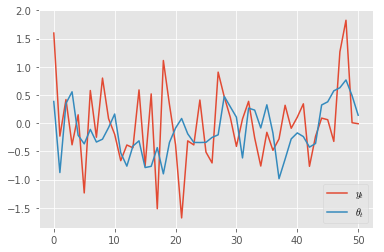

In [3]:
plt.plot(y_obs, label=r'$y_t$') 
plt.plot(theta_true,label=r'$\theta_t$')
print(y_obs)
print(theta_true)
plt.legend()

In [4]:
#define the likelihood function used
#TODO: Add random variable component that can be called to generate posterior predictive.
class univautoreg(Continuous):
    def __init__(self,theta0=None, v=None, *args, **kwargs):
        super(univautoreg, self).__init__(*args, **kwargs)
        self.theta0 = theta0
        self.mean = tt.as_tensor_variable(0.)
        self.v=v
    def logp(self,value):
        theta0=self.theta0
        v=self.v
        theta=theta0.flatten()
        valuenew=value.flatten()
        #consider doing tensor version of this to speed up
        def calc_next_err(value,last_value,theta_t,theta_last,vin): #calculates next period error epsilon_t, nu_t
            this_period=pm.math.stack([value,theta_t],axis=0)
            meanval=theta_t*last_value
            last_period=pm.math.stack([meanval,theta_last],axis=0)
            err=this_period-last_period
            errnew=err.reshape([2,1])
            lik= MvNormal.dist(mu=np.zeros(2), cov=vin).logp(errnew) #likelihood of each is from multivariate normal #check if possible misspecification here
            return lik
        err_like, _  = scan(fn=calc_next_err,
                         sequences=[dict(input=valuenew, taps=[0,-1]),dict(input=theta, taps=[0,-1])],
                         outputs_info=[None],
                         non_sequences=[v]
                        )
        liketotal=tt.sum(err_like)
        return (liketotal)

In [ ]:
#Parameters needed to make model work.
theta_bar = .5
P_bar = 2
P_bar_sd = np.sqrt(P_bar)
with pm.Model() as model1:
    #Variance function
    BoundedNorm = pm.Bound(pm.Normal,lower=-1.0,upper=1.0) #defines bounded normal
    BoundedGRW = pm.Bound(pm.GaussianRandomWalk, lower=-1.0, upper=1.0) #defines bounded gaussian random walk
    packed_cov = pm.LKJCholeskyCov('chol_cov', n=2, eta=2., sd_dist=pm.HalfCauchy.dist(beta=1.5)) #equivalent of p(V), gives prior on cholesky of COV
    chol = pm.expand_packed_triangular(2,packed_cov) #generates cholesky decomp. from packed triangular matrix in previous problem
    v=pm.Deterministic('v',tt.dot(chol,chol.T)) #generates cov matrix from cholesky decomposition
    sdtemp=tt.sqrt(tt.diag(v)) #takes sqrt of each variance to get sd
    sd = sdtemp[1] #recovers sd
    #Theta prior
    thetainit=BoundedNorm.dist(mu=theta_bar,sd=P_bar_sd)
    #Theta Updating Process
    theta=BoundedGRW('theta', sd=sd, init=thetainit, shape=len(y_obs)) #gives prior on sequence of thetas
    #Likelihood function
    like = univautoreg('like', theta0=theta, v=v, observed=y_obs) #specifies model from class
    tracemodel1 = pm.sample(tune=1000,samples=1000) #runs sample on posterior

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta_interval__, chol_cov_cholesky_cov_packed__]
  3%|▎         | 45/1500 [01:52<1:00:48,  2.51s/it]

In [ ]:
pm.summary(tracemodel1)

In [ ]:
pm.hpd(tracemodel1)

In [ ]:
pm.quantiles(tracemodel1)

In [ ]:
pm.traceplot(tracemodel1[:], alpha=.3)

In [ ]:
pm.autocorrplot(tracemodel1[0::2])

In [ ]:
sns.kdeplot(tracemodel1[::2]['theta'])

In [ ]:
sns.kdeplot(tracemodel1[::2]['v'])

In [ ]:
model1.vars

In [ ]:
model1.deterministics
#postpred= pm.sample_ppc(tracemodel1,samples=500, model=model1, size=100)

In [ ]:
plt.hist(postpred['like'], alpha=0.2, normed=True)
sns.kdeplot(tr1['mu']);